In [1]:
# Necessary Imports
import os
import os.path
import urllib
from urllib import request
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import keras
import tensorflow as tf

In [2]:
# Download Data Files if Not Currently Downloaded into the Current Working Directory
DOWNLOAD_DIR = "/content/"

# Set Needed File Names
needed_files = ["matchups.xlsx"]

# Remove Space from Needed File Names
file_urls = []
for filename in needed_files:
  file_urls.append(filename.replace(' ', '%20'))

# Read and Download Needed Files
for i in range(len(needed_files)):
    if not os.path.isfile(DOWNLOAD_DIR + needed_files[i]):
      DOWNLOAD_ROOT = "https://raw.githubusercontent.com/LMastro99/Sports-Betting-Module/main/season-data/cleaning/subsets/"
      url = DOWNLOAD_ROOT + file_urls[i]
      urllib.request.urlretrieve(url, DOWNLOAD_DIR + needed_files[i])
    print("Downloaded", needed_files[i])    

    # Create Dataframe "Layers" with the Data From the XLSX Files
    xls = pd.ExcelFile(DOWNLOAD_DIR + needed_files[i])
    download = pd.read_excel(xls, '2007-08')
    download = download.append(pd.read_excel(xls, '2008-09'))
    download = download.append(pd.read_excel(xls, '2009-10'))
    download = download.append(pd.read_excel(xls, '2010-11'))
    download = download.append(pd.read_excel(xls, '2011-12'))
    download = download.append(pd.read_excel(xls, '2012-13'))
    download = download.append(pd.read_excel(xls, '2013-14'))
    download = download.append(pd.read_excel(xls, '2014-15'))
    download = download.append(pd.read_excel(xls, '2015-16'))
    download = download.append(pd.read_excel(xls, '2016-17'))
    download = download.append(pd.read_excel(xls, '2017-18'))
    download = download.append(pd.read_excel(xls, '2018-19'))
    download = download.append(pd.read_excel(xls, '2019-20'))
    download = download.append(pd.read_excel(xls, '2020-21'))

# Convert Matchups Data to DataFrame
matchups = download
idx = pd.Index(matchups['Unnamed: 0'], name='')
matchups = matchups.reindex(idx)
matchups = matchups.drop(columns = 'Unnamed: 0')
matchups = matchups.reset_index(drop = True)

Downloaded matchups.xlsx


In [3]:
# Show First 5 Matchups
matchups[:5]

,Season,Date,Away Team,Away 1st,Away 2nd,Away 3rd,Away 4th,Away Final,Away ML,Home Team,Home 1st,Home 2nd,Home 3rd,Home 4th,Home Final,Home ML,Home Favorite,Differential
0,2007-08,2007-10-30,Portland,26,23,28,20,97,900,SanAntonio,29,30,22,25,106,-1400,1,9
1,2007-08,2007-10-30,Utah,28,34,24,31,117,100,GoldenState,30,21,21,24,96,-120,1,-21
2,2007-08,2007-10-30,Houston,16,27,27,25,95,-230,LALakers,25,18,19,31,93,190,0,2
3,2007-08,2007-10-31,Philadelphia,22,28,17,30,97,255,Toronto,24,34,23,25,106,-305,1,9
4,2007-08,2007-10-31,Washington,23,22,25,33,110,-125,Indiana,28,20,22,33,119,105,0,-9


In [4]:
# Show Last 5 Matchups
matchups[-5:]

,Season,Date,Away Team,Away 1st,Away 2nd,Away 3rd,Away 4th,Away Final,Away ML,Home Team,Home 1st,Home 2nd,Home 3rd,Home 4th,Home Final,Home ML,Home Favorite,Differential
17333,2020-21,2021-04-19,OklahomaCity,25,33,21,28,107,650,Washington,38,26,24,31,119,-1000,1,12
17334,2020-21,2021-04-19,Phoenix,24,31,28,33,128,130,Milwaukee,25,29,36,26,127,-150,1,-1
17335,2020-21,2021-04-19,SanAntonio,36,19,27,27,109,-160,Indiana,21,23,22,28,94,140,0,15
17336,2020-21,2021-04-19,Memphis,35,25,35,21,137,280,Denver,27,29,31,29,139,-340,1,2
17337,2020-21,2021-04-19,Utah,29,23,33,26,111,-270,LALakers,23,19,23,32,97,230,0,14


In [5]:
# Show Column Data Types
matchups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17338 entries, 0 to 17337
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Season         17338 non-null  object        
 1   Date           17338 non-null  datetime64[ns]
 2   Away Team      17338 non-null  object        
 3   Away 1st       17338 non-null  int64         
 4   Away 2nd       17338 non-null  int64         
 5   Away 3rd       17338 non-null  int64         
 6   Away 4th       17338 non-null  int64         
 7   Away Final     17338 non-null  int64         
 8   Away ML        17338 non-null  int64         
 9   Home Team      17338 non-null  object        
 10  Home 1st       17338 non-null  int64         
 11  Home 2nd       17338 non-null  int64         
 12  Home 3rd       17338 non-null  int64         
 13  Home 4th       17338 non-null  int64         
 14  Home Final     17338 non-null  int64         
 15  Home ML        1733

In [6]:
# Determine Margins
num_margins = int (input('Total Number of Margins: '))
ub = []
lb = []
margins = []
for i in range(num_margins):
  curr_lb = input('\nLower Bound #' + str (i + 1) + ': ')
  lb.append(curr_lb)
  curr_ub =  input('Upper Bound #' + str (i + 1) + ': ')
  ub.append(curr_ub)
  if (curr_lb == '-'):
    curr_margin = 'UND ' + str (int (curr_ub) * -1) + '+'
  elif (curr_ub == '+'):
    curr_margin = 'FAV ' + curr_lb + '+'
  else:
    if (int (curr_lb) < 0 and int (curr_ub) < 0):
      curr_margin = 'UND ' + str (int (curr_ub) * -1) + '-' + str (int (curr_lb) * -1)
    elif (int (curr_lb) < 0 and int (curr_ub) > 0):
      curr_margin = 'UND ' + str (int (curr_lb) * -1) + '-' + 'FAV ' + curr_ub
    elif (int (curr_lb) > 0 and int (curr_ub) > 0):
      curr_margin = 'FAV ' + curr_lb + '-' + curr_ub
  margins.append(curr_margin)
print('\nMargins:', margins)

Total Number of Margins: 7

Lower Bound #1: -
Upper Bound #1: -11

Lower Bound #2: -10
Upper Bound #2: -1

Lower Bound #3: 1
Upper Bound #3: 5

Lower Bound #4: 6
Upper Bound #4: 10

Lower Bound #5: 11
Upper Bound #5: 20

Lower Bound #6: 21
Upper Bound #6: 30

Lower Bound #7: 31
Upper Bound #7: +

Margins: ['UND 11+', 'UND 1-10', 'FAV 1-5', 'FAV 6-10', 'FAV 11-20', 'FAV 21-30', 'FAV 31+']


In [7]:
# Create ['Margin'] Column
matchups['Margin'] = matchups['Differential'].astype('object')
for m in range(len(matchups)):
  curr_diff = matchups['Differential'][m]
  for b in range(1, num_margins):
    if (curr_diff <= int (lb[b])):
      matchups['Margin'][m] = margins[b - 1]
      break
    elif (curr_diff > int (lb[-1])):
      matchups['Margin'][m] = margins[-1]
      break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
# Show First 5 Matchups
matchups.head()

,Season,Date,Away Team,Away 1st,Away 2nd,Away 3rd,Away 4th,Away Final,Away ML,Home Team,Home 1st,Home 2nd,Home 3rd,Home 4th,Home Final,Home ML,Home Favorite,Differential,Margin
0,2007-08,2007-10-30,Portland,26,23,28,20,97,900,SanAntonio,29,30,22,25,106,-1400,1,9,FAV 6-10
1,2007-08,2007-10-30,Utah,28,34,24,31,117,100,GoldenState,30,21,21,24,96,-120,1,-21,UND 11+
2,2007-08,2007-10-30,Houston,16,27,27,25,95,-230,LALakers,25,18,19,31,93,190,0,2,FAV 1-5
3,2007-08,2007-10-31,Philadelphia,22,28,17,30,97,255,Toronto,24,34,23,25,106,-305,1,9,FAV 6-10
4,2007-08,2007-10-31,Washington,23,22,25,33,110,-125,Indiana,28,20,22,33,119,105,0,-9,UND 1-10


In [9]:
# Show Column Data Types
matchups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17338 entries, 0 to 17337
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Season         17338 non-null  object        
 1   Date           17338 non-null  datetime64[ns]
 2   Away Team      17338 non-null  object        
 3   Away 1st       17338 non-null  int64         
 4   Away 2nd       17338 non-null  int64         
 5   Away 3rd       17338 non-null  int64         
 6   Away 4th       17338 non-null  int64         
 7   Away Final     17338 non-null  int64         
 8   Away ML        17338 non-null  int64         
 9   Home Team      17338 non-null  object        
 10  Home 1st       17338 non-null  int64         
 11  Home 2nd       17338 non-null  int64         
 12  Home 3rd       17338 non-null  int64         
 13  Home 4th       17338 non-null  int64         
 14  Home Final     17338 non-null  int64         
 15  Home ML        1733

In [10]:
# Create ['Favorite ML'] and ['Underdog ML'] Columns
matchups['Favorite ML'] = matchups['Home ML'] 
matchups['Underdog ML'] = matchups['Home ML']
for m in range(len(matchups)):
  curr_away_ml = matchups['Away ML'][m]
  curr_home_ml = matchups['Home ML'][m]
  curr_fav_ml = np.array([curr_away_ml, curr_home_ml]).min()
  curr_und_ml = np.array([curr_away_ml, curr_home_ml]).max()
  matchups['Favorite ML'][m] = curr_fav_ml
  matchups['Underdog ML'][m] = curr_und_ml

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# Show First 5 Matchups
matchups.head()

,Season,Date,Away Team,Away 1st,Away 2nd,Away 3rd,Away 4th,Away Final,Away ML,Home Team,Home 1st,Home 2nd,Home 3rd,Home 4th,Home Final,Home ML,Home Favorite,Differential,Margin,Favorite ML,Underdog ML
0,2007-08,2007-10-30,Portland,26,23,28,20,97,900,SanAntonio,29,30,22,25,106,-1400,1,9,FAV 6-10,-1400,900
1,2007-08,2007-10-30,Utah,28,34,24,31,117,100,GoldenState,30,21,21,24,96,-120,1,-21,UND 11+,-120,100
2,2007-08,2007-10-30,Houston,16,27,27,25,95,-230,LALakers,25,18,19,31,93,190,0,2,FAV 1-5,-230,190
3,2007-08,2007-10-31,Philadelphia,22,28,17,30,97,255,Toronto,24,34,23,25,106,-305,1,9,FAV 6-10,-305,255
4,2007-08,2007-10-31,Washington,23,22,25,33,110,-125,Indiana,28,20,22,33,119,105,0,-9,UND 1-10,-125,105


In [12]:
# Show Column Data Types
matchups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17338 entries, 0 to 17337
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Season         17338 non-null  object        
 1   Date           17338 non-null  datetime64[ns]
 2   Away Team      17338 non-null  object        
 3   Away 1st       17338 non-null  int64         
 4   Away 2nd       17338 non-null  int64         
 5   Away 3rd       17338 non-null  int64         
 6   Away 4th       17338 non-null  int64         
 7   Away Final     17338 non-null  int64         
 8   Away ML        17338 non-null  int64         
 9   Home Team      17338 non-null  object        
 10  Home 1st       17338 non-null  int64         
 11  Home 2nd       17338 non-null  int64         
 12  Home 3rd       17338 non-null  int64         
 13  Home 4th       17338 non-null  int64         
 14  Home Final     17338 non-null  int64         
 15  Home ML        1733

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ff91b0950>,
      dtype=object)

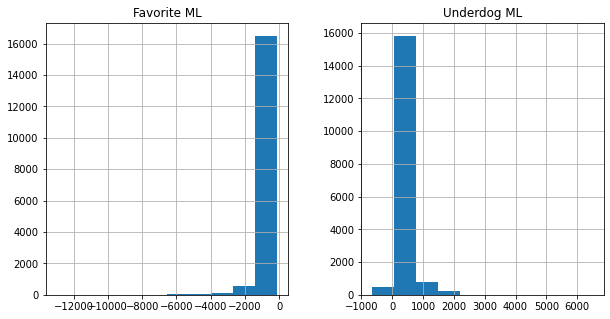

In [13]:
# Show ['Favorite ML'] and ['Underdog ML'] Distribution
matchups[['Favorite ML', 'Underdog ML']].hist(figsize = (10, 5))

In [14]:
# Drop 'Outliers'
matchups = matchups[matchups['Underdog ML'] >= -120]
matchups = matchups[matchups['Underdog ML'] < matchups['Underdog ML'].quantile(.85)]
matchups.reset_index(drop = True, inplace = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ff8fc7190>,
      dtype=object)

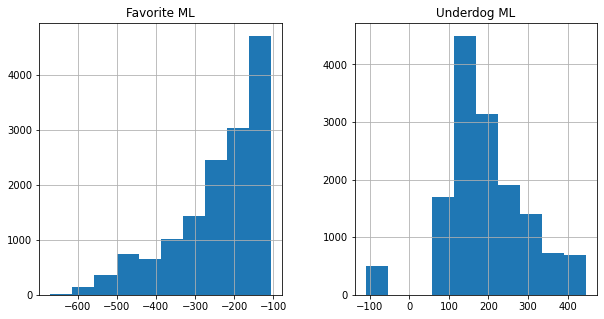

In [15]:
# Show ['Favorite ML'] and ['Underdog ML'] Distribution
matchups[['Favorite ML', 'Underdog ML']].hist(figsize = (10, 5))

In [16]:
# Create ['Favorite/Underdog 1st'], ['Favorite/Underdog 2nd'], 
# ['Favorite/Underdog 3rd'], ['Favorite/Underdog 4th'], and 
# ['Favorite/Underdog Final'] Columns
matchups['Favorite Team'] = matchups['Home Team'] 
matchups['Favorite 1st'] = matchups['Home 1st'] 
matchups['Favorite 2nd'] = matchups['Home 2nd'] 
matchups['Favorite 3rd'] = matchups['Home 3rd'] 
matchups['Favorite 4th'] = matchups['Home 4th'] 
matchups['Favorite Final'] = matchups['Home Final'] 
matchups['Underdog Team'] = matchups['Home Team'] 
matchups['Underdog 1st'] = matchups['Home 1st'] 
matchups['Underdog 2nd'] = matchups['Home 2nd'] 
matchups['Underdog 3rd'] = matchups['Home 3rd'] 
matchups['Underdog 4th'] = matchups['Home 4th'] 
matchups['Underdog Final'] = matchups['Home Final'] 
for m in range(len(matchups)):
  curr_away_team = matchups['Away Team'].iloc[m] 
  curr_away_1st = matchups['Away 1st'].iloc[m]
  curr_away_2nd = matchups['Away 2nd'].iloc[m]
  curr_away_3rd = matchups['Away 3rd'].iloc[m]
  curr_away_4th = matchups['Away 4th'].iloc[m]
  curr_away_final = matchups['Away Final'].iloc[m]
  curr_home_team = matchups['Home Team'].iloc[m] 
  curr_home_1st = matchups['Home 1st'].iloc[m]
  curr_home_2nd = matchups['Home 2nd'].iloc[m]
  curr_home_3rd = matchups['Home 3rd'].iloc[m]
  curr_home_4th = matchups['Home 4th'].iloc[m]
  curr_home_final = matchups['Home Final'].iloc[m]
  if (matchups['Home Favorite'].iloc[m] == 1):
    matchups['Favorite Team'].loc[m] = curr_home_team
    matchups['Favorite 1st'].iloc[m] = curr_home_1st
    matchups['Favorite 2nd'].iloc[m] = curr_home_2nd
    matchups['Favorite 3rd'].iloc[m] = curr_home_3rd
    matchups['Favorite 4th'].iloc[m] = curr_home_4th
    matchups['Favorite Final'].iloc[m] = curr_home_final
    matchups['Underdog Team'].loc[m] = curr_away_team
    matchups['Underdog 1st'].iloc[m] = curr_away_1st
    matchups['Underdog 2nd'].iloc[m] = curr_away_2nd
    matchups['Underdog 3rd'].iloc[m] = curr_away_3rd
    matchups['Underdog 4th'].iloc[m] = curr_away_4th 
    matchups['Underdog Final'].iloc[m] = curr_away_final
  else:
    matchups['Underdog Team'].loc[m] = curr_home_team
    matchups['Underdog 1st'].iloc[m] = curr_home_1st
    matchups['Underdog 2nd'].iloc[m] = curr_home_2nd
    matchups['Underdog 3rd'].iloc[m] = curr_home_3rd
    matchups['Underdog 4th'].iloc[m] = curr_home_4th
    matchups['Underdog Final'].iloc[m] = curr_home_final
    matchups['Favorite Team'].loc[m] = curr_away_team
    matchups['Favorite 1st'].iloc[m] = curr_away_1st
    matchups['Favorite 2nd'].iloc[m] = curr_away_2nd
    matchups['Favorite 3rd'].iloc[m] = curr_away_3rd
    matchups['Favorite 4th'].iloc[m] = curr_away_4th 
    matchups['Favorite Final'].iloc[m] = curr_away_final

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
# Drop ['Home/Away'] Columns
matchups = matchups.drop(columns = ['Away Team', 'Away 1st', 'Away 2nd', 
                                    'Away 3rd', 'Away 4th', 'Away Final', 
                                    'Away ML', 'Home Team', 'Home 1st',
                                    'Home 2nd', 'Home 3rd', 'Home 4th', 
                                    'Home Final', 'Home ML'])

In [18]:
# Reorder Columns
matchups = matchups.reindex(['Season', 'Date', 'Favorite Team', 'Favorite ML', 
                    'Favorite 1st', 'Favorite 2nd', 'Favorite 3rd', 
                    'Favorite 4th', 'Favorite Final', 'Underdog Team', 
                    'Underdog ML', 'Underdog 1st', 'Underdog 2nd', 
                    'Underdog 3rd', 'Underdog 4th', 'Underdog Final', 
                    'Home Favorite', 'Differential', 'Margin'], axis = 'columns')

In [19]:
# Show Column Data Types
matchups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14556 entries, 0 to 14555
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Season          14556 non-null  object        
 1   Date            14556 non-null  datetime64[ns]
 2   Favorite Team   14556 non-null  object        
 3   Favorite ML     14556 non-null  int64         
 4   Favorite 1st    14556 non-null  int64         
 5   Favorite 2nd    14556 non-null  int64         
 6   Favorite 3rd    14556 non-null  int64         
 7   Favorite 4th    14556 non-null  int64         
 8   Favorite Final  14556 non-null  int64         
 9   Underdog Team   14556 non-null  object        
 10  Underdog ML     14556 non-null  int64         
 11  Underdog 1st    14556 non-null  int64         
 12  Underdog 2nd    14556 non-null  int64         
 13  Underdog 3rd    14556 non-null  int64         
 14  Underdog 4th    14556 non-null  int64         
 15  Un

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ff7f57410>,
      dtype=object)

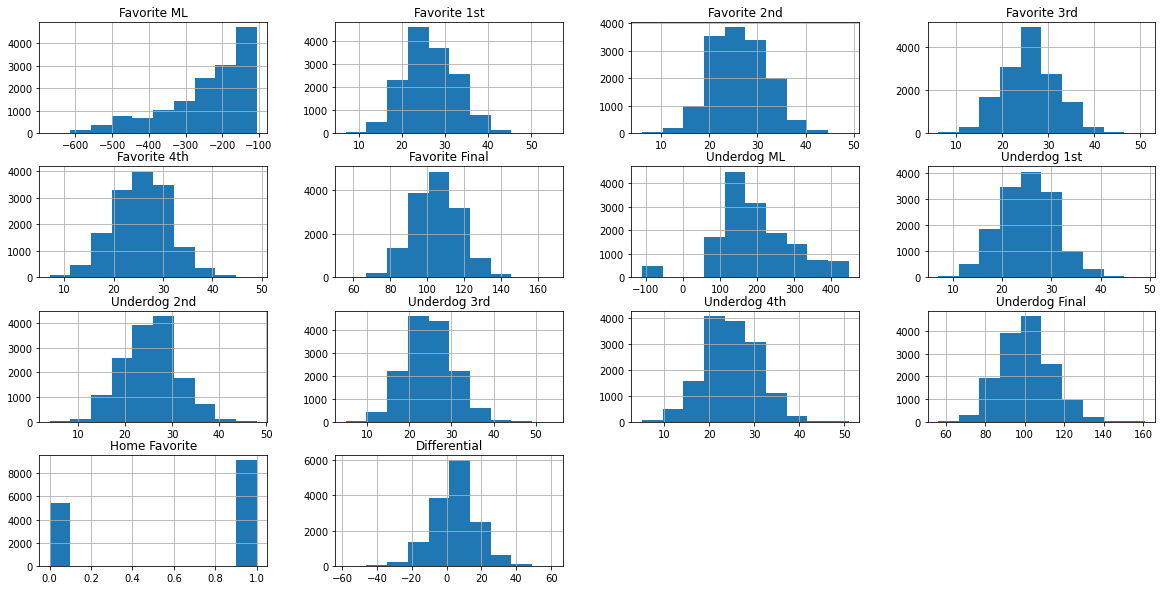

In [20]:
# Show Matchups Distribution
matchups.hist(figsize = (20, 10))

In [21]:
# Show First 5 Matchups
matchups[:5]

,Season,Date,Favorite Team,Favorite ML,Favorite 1st,Favorite 2nd,Favorite 3rd,Favorite 4th,Favorite Final,Underdog Team,Underdog ML,Underdog 1st,Underdog 2nd,Underdog 3rd,Underdog 4th,Underdog Final,Home Favorite,Differential,Margin
0,2007-08,2007-10-30,GoldenState,-120,30,21,21,24,96,Utah,100,28,34,24,31,117,1,-21,UND 11+
1,2007-08,2007-10-30,Houston,-230,16,27,27,25,95,LALakers,190,25,18,19,31,93,0,2,FAV 1-5
2,2007-08,2007-10-31,Toronto,-305,24,34,23,25,106,Philadelphia,255,22,28,17,30,97,1,9,FAV 6-10
3,2007-08,2007-10-31,Washington,-125,23,22,25,33,110,Indiana,105,28,20,22,33,119,0,-9,UND 1-10
4,2007-08,2007-10-31,Orlando,-295,24,24,35,19,102,Milwaukee,245,24,22,16,21,83,1,19,FAV 11-20


In [22]:
# Split X and Y Data
x_data = matchups[['Season', 'Date', 'Favorite Team', 'Favorite ML', 
                         'Favorite 1st', 'Favorite 2nd', 'Favorite 3rd', 
                         'Favorite 4th', 'Favorite Final', 'Underdog Team', 
                         'Underdog ML', 'Underdog 1st', 'Underdog 2nd',
                         'Underdog 3rd', 'Underdog 4th', 'Underdog Final', 
                         'Home Favorite']]
y_data = matchups[['Differential', 'Margin']]
x_data.shape, y_data.shape

((14556, 17), (14556, 2))

In [23]:
# Drop Quarters Data
x_data = x_data.drop(columns = ['Favorite 1st', 'Favorite 2nd', 
                                    'Favorite 3rd', 'Favorite 4th', 
                                    'Favorite Final', 'Underdog 1st', 
                                    'Underdog 2nd', 'Underdog 3rd', 
                                    'Underdog 4th', 'Underdog Final'])

In [24]:
# Drop ['Season'] and ['Date'] Columns
x_data = x_data.drop(columns = ['Season', 'Date'])

In [25]:
# Drop ['Favorite/Underdog Team'] Columns
x_data = x_data.drop(columns = ['Favorite Team', 'Underdog Team'])

In [26]:
# Split X and Y into Train, Valid, Test, and Pred Sets
x_train, x_test_full, y_train, y_test_full = train_test_split(x_data, y_data, train_size = 0.5, shuffle = False)
x_valid, x_test, y_valid, y_test = train_test_split(x_test_full, y_test_full, train_size = 0.6, shuffle = False)
x_test, x_pred, y_test, y_true = train_test_split(x_test, y_test, test_size = 3, shuffle = False)
print('X Data:', x_train.shape, x_valid.shape, x_test.shape, x_pred.shape)
print('Y Data:', y_train.shape, y_valid.shape, y_test.shape, y_true.shape)

X Data: (7278, 3) (4366, 3) (2909, 3) (3, 3)
Y Data: (7278, 2) (4366, 2) (2909, 2) (3, 2)


In [27]:
# Create Data Transformation Pipeline
x_cat_attribs = []
x_num_attribs = ['Favorite ML', 'Underdog ML', 'Home Favorite']
x_num_pipeline = Pipeline( [
 ('minmax_scaler', MinMaxScaler()),   
])
x_cat_pipeline = Pipeline( [
 ('ohe', OneHotEncoder()),                          
])
x_full_pipeline = ColumnTransformer( [
    ('x_num', x_num_pipeline, x_num_attribs),
    ('x_cat', x_cat_pipeline, x_cat_attribs),
])

In [28]:
# Transform X Train, Valid, Test, and Pred Data Sets
x_train_trans = x_full_pipeline.fit_transform(x_train)
x_train_trans = x_train_trans.reshape(x_train_trans.shape[0], x_train_trans.shape[1], 1)
x_valid_trans = x_full_pipeline.transform(x_valid)
x_valid_trans = x_valid_trans.reshape(x_valid_trans.shape[0], x_valid_trans.shape[1], 1)
x_test_trans = x_full_pipeline.transform(x_test)
x_test_trans = x_test_trans.reshape(x_test_trans.shape[0], x_test_trans.shape[1], 1)
x_pred_trans = x_full_pipeline.transform(x_pred)
x_pred_trans = x_pred_trans.reshape(x_pred_trans.shape[0], x_pred_trans.shape[1], 1)

In [29]:
# Scale ['Differential'] Column
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train[['Differential']]).reshape(-1, 1)
y_valid_scaled = y_scaler.transform(y_valid[['Differential']]).reshape(-1, 1)
y_test_scaled = y_scaler.transform(y_test[['Differential']]).reshape(-1, 1)
y_true_scaled = y_scaler.transform(y_true[['Differential']]).reshape(-1, 1)

In [30]:
# Transform ['Margin'] Column
y_transformer = LabelEncoder()
y_train_trans = y_transformer.fit_transform(y_train['Margin']).reshape(-1, 1)
y_valid_trans = y_transformer.transform(y_valid['Margin']).reshape(-1, 1)
y_test_trans = y_transformer.transform(y_test['Margin']).reshape(-1, 1)
y_true_trans = y_transformer.transform(y_true['Margin']).reshape(-1, 1)

In [31]:
# Create a Baseline
baseline = []
for i in range(1, num_margins + 1):
  acc = round(i / num_margins, 2)
  baseline.append(acc)

In [32]:
# Define Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, mode='min')

In [33]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [34]:
# Create Simple Multiclassification Model (Neaural Networks)
model = Sequential()
model.add(Flatten())
model.add(Dense(num_margins, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001658), metrics = ['accuracy'])
history = model.fit(x_train_trans, y_train_trans, epochs=500, batch_size = 150,
                    validation_data=(x_valid_trans, y_valid_trans), callbacks = early_stopping)

Epoch 1/500
49/49 [==============================] - 1s 12ms/step - loss: 1.9746 - accuracy: 0.1757 - val_loss: 1.9077 - val_accuracy: 0.1757
Epoch 2/500
49/49 [==============================] - 0s 3ms/step - loss: 1.9006 - accuracy: 0.1886 - val_loss: 1.8548 - val_accuracy: 0.2107
Epoch 3/500
49/49 [==============================] - 0s 3ms/step - loss: 1.8382 - accuracy: 0.2033 - val_loss: 1.8253 - val_accuracy: 0.2135
Epoch 4/500
49/49 [==============================] - 0s 3ms/step - loss: 1.8154 - accuracy: 0.2055 - val_loss: 1.8085 - val_accuracy: 0.2142
Epoch 5/500
49/49 [==============================] - 0s 2ms/step - loss: 1.8026 - accuracy: 0.2167 - val_loss: 1.7978 - val_accuracy: 0.2437
Epoch 6/500
49/49 [==============================] - 0s 3ms/step - loss: 1.7882 - accuracy: 0.2493 - val_loss: 1.7914 - val_accuracy: 0.2510
Epoch 7/500
49/49 [==============================] - 0s 3ms/step - loss: 1.7813 - accuracy: 0.2465 - val_loss: 1.7866 - val_accuracy: 0.2517
Epoch 8/500


In [35]:
# Function to plot Loss vs. Validation Loss
def plot_loss_curve(history):
    plt.plot(history.history['loss'], label = 'Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.grid(True)
    plt.xlabel("EPOCHS")
    plt.legend(loc = 'upper left')
    plt.show()

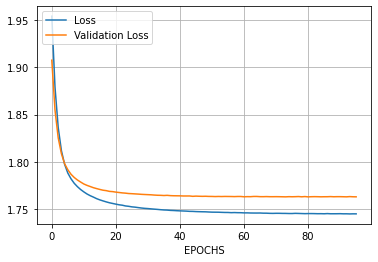

In [36]:
# Show Loss Curve
plot_loss_curve(history)

In [37]:
# Function to plot Accuracy vs. Validation Accuracy
def plot_accuracy_curve(history):
    plt.plot(history.history['accuracy'], label = 'Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.grid(True)
    plt.xlabel("EPOCHS")
    plt.legend(loc = 'upper left')
    plt.show()

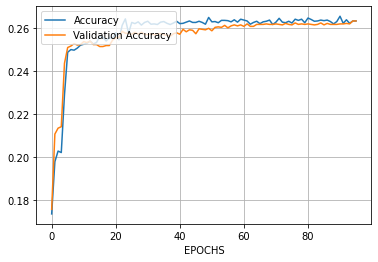

In [38]:
# Show Accuracy Curve
plot_accuracy_curve(history)

In [39]:
# Make Test Predictions
y_test_pred = model.predict(x_test_trans)
y_test_margin = y_test_trans

In [40]:
# Function to Get 'N-Best' Guesses
guesses = []
accuracy = []
accuracies = []
win = 0
for i in range(1, num_margins + 1):
  current_guess = []
  current_win = 0
  for j in range(len(y_test_pred)):
    current_guesses = y_test_pred[j]
    current_guess.append(current_guesses.argsort()[-i])
    if (y_test_trans[j] == current_guess[-1]):
      current_win = current_win + 1
  guesses.append(current_guess)
  win = win + current_win
  accuracy.append(win / len(y_test_trans))
accuracies.append(accuracy)

In [41]:
# Make 3 Set Predictions
y_margin_pred = model.predict(x_pred_trans)
y_true_margin = y_true_trans

In [44]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [45]:
# Create Deep Multiclassification Model (Neaural Networks)
model = Sequential()
model.add(Flatten())
model.add(Dense(2))
model.add(Dense(num_margins, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001855), metrics = ['accuracy'])
history = model.fit(x_train_trans, y_train_trans, epochs=500, batch_size = 150,
                    validation_data=(x_valid_trans, y_valid_trans), callbacks = early_stopping)

Epoch 1/500
49/49 [==============================] - 1s 6ms/step - loss: 1.9951 - accuracy: 0.0954 - val_loss: 1.9364 - val_accuracy: 0.2073
Epoch 2/500
49/49 [==============================] - 0s 3ms/step - loss: 1.9253 - accuracy: 0.2123 - val_loss: 1.8918 - val_accuracy: 0.2114
Epoch 3/500
49/49 [==============================] - 0s 3ms/step - loss: 1.8755 - accuracy: 0.2105 - val_loss: 1.8595 - val_accuracy: 0.2082
Epoch 4/500
49/49 [==============================] - 0s 3ms/step - loss: 1.8457 - accuracy: 0.2140 - val_loss: 1.8323 - val_accuracy: 0.2089
Epoch 5/500
49/49 [==============================] - 0s 3ms/step - loss: 1.8190 - accuracy: 0.2073 - val_loss: 1.8089 - val_accuracy: 0.2107
Epoch 6/500
49/49 [==============================] - 0s 3ms/step - loss: 1.7944 - accuracy: 0.2212 - val_loss: 1.7927 - val_accuracy: 0.2112
Epoch 7/500
49/49 [==============================] - 0s 3ms/step - loss: 1.7796 - accuracy: 0.2325 - val_loss: 1.7829 - val_accuracy: 0.2542
Epoch 8/500
4

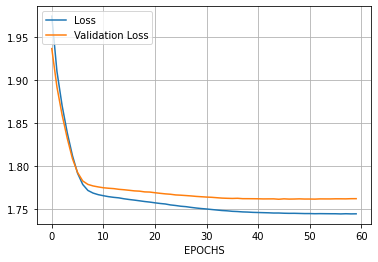

In [46]:
# Show Loss Curve
plot_loss_curve(history)

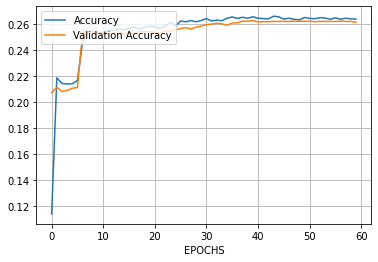

In [47]:
# Show Accuracy Curve
plot_accuracy_curve(history)

In [48]:
# Make Test Predictions
y_test_pred = model.predict(x_test_trans)
y_test_margin = y_test_trans

In [49]:
# Function to Get 'N-Best' Guesses
guesses = []
accuracy = []
win = 0
for i in range(1, num_margins + 1):
  current_guess = []
  current_win = 0
  for j in range(len(y_test_pred)):
    current_guesses = y_test_pred[j]
    current_guess.append(current_guesses.argsort()[-i])
    if (y_test_trans[j] == current_guess[-1]):
      current_win = current_win + 1
  guesses.append(current_guess)
  win = win + current_win
  accuracy.append(win / len(y_test_trans))
accuracies.append(accuracy)

In [50]:
# Make 3 Set Predictions
y_margin_pred = model.predict(x_pred_trans)
y_true_margin = y_true_trans

In [52]:
# Create Simple Support Vector Machine
clf = SVC(probability = True, random_state = 42)
clf.fit(x_train_trans.reshape(-1, 3), y_train_trans.reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [53]:
# Make Test Predictions
y_test_pred = clf.predict_proba(x_test_trans.reshape(-1, 3))

In [54]:
# Function to Get 'N-Best' Guesses
guesses = []
accuracy = []
win = 0
for i in range(1, num_margins + 1):
  current_guess = []
  current_win = 0
  for j in range(len(y_test_pred)):
    current_guesses = y_test_pred[j]
    current_guess.append(current_guesses.argsort()[-i])
    if (y_test_trans[j] == current_guess[-1]):
      current_win = current_win + 1
  guesses.append(current_guess)
  win = win + current_win
  accuracy.append(win / len(y_test_trans))
accuracies.append(accuracy)

In [55]:
# Make 3 Set Predictions
y_margin_pred = model.predict(x_pred_trans)
y_true_margin = y_true_trans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


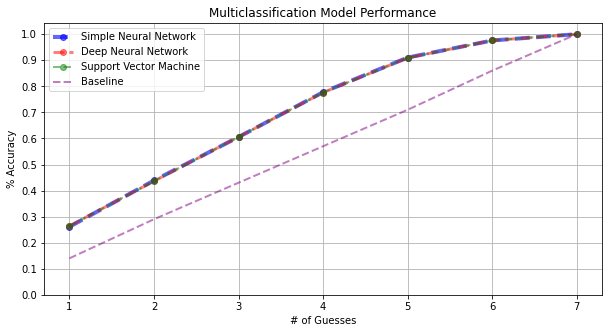

In [57]:
# Visualize Performance
plt.figure(figsize = (10, 5))
plt.xlabel('# of Guesses')
plt.ylabel('% Accuracy')
plt.plot(np.arange(1, 8, 1), accuracies[0], 'bo', linestyle = 'dashed', label = 'Simple Neural Network', linewidth = 4, alpha = 0.6)
plt.plot(np.arange(1, 8, 1), accuracies[1], 'ro', linestyle = 'dashed', label = 'Deep Neural Network', linewidth = 3, alpha = 0.5)
plt.plot(np.arange(1, 8, 1), accuracies[1], 'go', linestyle = 'dashed', label = 'Support Vector Machine', linewidth = 2, alpha = 0.5)
plt.plot(np.arange(1, 8, 1), baseline, 'purple', linestyle = 'dashed', label = 'Baseline', linewidth = 2, alpha = 0.5)
plt.legend(loc = 'upper left')
plt.yticks(list(np.arange(0, 1.1, 0.1)))
plt.title('Multiclassification Model Performance')
plt.grid(True)
plt.axes().set_facecolor('white')

In [58]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [59]:
# Create Simple Regression Model (Neaural Networks)
model = Sequential()
model.add(Flatten())
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.00015), metrics = ['accuracy'])
history = model.fit(x_train_trans, y_train_scaled, epochs=500, batch_size = 150,
                    validation_data=(x_valid_trans, y_valid_scaled), callbacks = early_stopping)

Epoch 1/500
49/49 [==============================] - 1s 5ms/step - loss: 0.2718 - accuracy: 7.1782e-05 - val_loss: 0.2606 - val_accuracy: 0.0000e+00
Epoch 2/500
49/49 [==============================] - 0s 2ms/step - loss: 0.2661 - accuracy: 6.3036e-05 - val_loss: 0.2538 - val_accuracy: 0.0000e+00
Epoch 3/500
49/49 [==============================] - 0s 3ms/step - loss: 0.2576 - accuracy: 1.4009e-05 - val_loss: 0.2423 - val_accuracy: 0.0000e+00
Epoch 4/500
49/49 [==============================] - 0s 2ms/step - loss: 0.2452 - accuracy: 8.2738e-06 - val_loss: 0.2275 - val_accuracy: 0.0000e+00
Epoch 5/500
49/49 [==============================] - 0s 3ms/step - loss: 0.2299 - accuracy: 8.2738e-06 - val_loss: 0.2115 - val_accuracy: 0.0000e+00
Epoch 6/500
49/49 [==============================] - 0s 2ms/step - loss: 0.2111 - accuracy: 1.6972e-05 - val_loss: 0.1947 - val_accuracy: 0.0000e+00
Epoch 7/500
49/49 [==============================] - 0s 2ms/step - loss: 0.2026 - accuracy: 1.6646e-04 - v

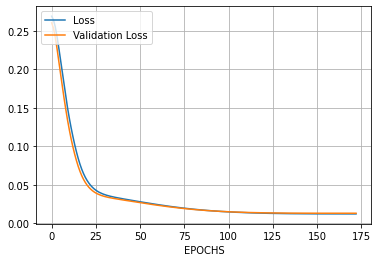

In [60]:
# Show Loss Curve
plot_loss_curve(history)

In [61]:
# Make Test Predictions
y_test_pred = model.predict(x_test_trans)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_test_diff = y_scaler.inverse_transform(y_test_scaled)

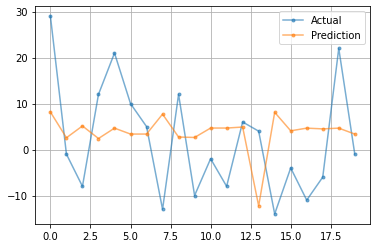

In [62]:
# Plot Actual vs Predicted
plot_actual_pred(y_test_diff[-20:], y_test_pred[-20:])

In [63]:
# Calculate Percent of Matchups Above/Below Prediction
count = 0
total = 0
for i in range(len(y_test_diff)):
  if (y_test_diff[i] < y_test_pred[i]):
    count = count + 1
  total = total + 1
print(str (round(count/total, 3) * 100) + '% Below')
print(str (round((total - count)/total, 3) * 100) + '% Above')

45.800000000000004% Below
54.2% Above


In [64]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [65]:
# Create Deep Regression Model (Neaural Networks)
model = Sequential()
model.add(LSTM(100, return_sequences = False, dropout = 0.05))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.00155))
history = model.fit(x_train_trans, y_train_scaled, epochs=500, batch_size = 150,
                    validation_data=(x_valid_trans, y_valid_scaled), callbacks = early_stopping)

Epoch 1/500
49/49 [==============================] - 3s 22ms/step - loss: 0.1207 - val_loss: 0.0163
Epoch 2/500
49/49 [==============================] - 1s 12ms/step - loss: 0.0182 - val_loss: 0.0148
Epoch 3/500
49/49 [==============================] - 1s 12ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 4/500
49/49 [==============================] - 1s 11ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 5/500
49/49 [==============================] - 1s 12ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 6/500
49/49 [==============================] - 1s 12ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 7/500
49/49 [==============================] - 1s 13ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 8/500
49/49 [==============================] - 1s 12ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 9/500
49/49 [==============================] - 1s 12ms/step - loss: 0.0120 - val_loss: 0.0127
Epoch 10/500
49/49 [==============================] - 1s 12ms/step - loss: 0.0123 - val_loss: 0.0129

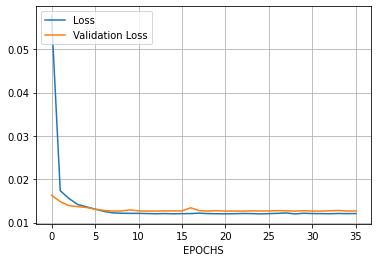

In [66]:
# Show Loss Curve
plot_loss_curve(history)

In [67]:
# Make Test Predictions
y_test_pred = model.predict(x_test_trans)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_test_diff = y_scaler.inverse_transform(y_test_scaled)

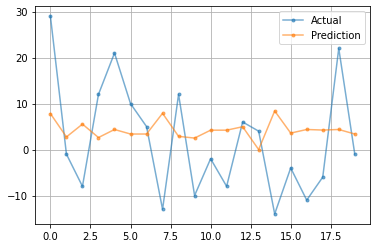

In [68]:
# Plot Actual vs Predicted
plot_actual_pred(y_test_diff[-20:], y_test_pred[-20:])

In [69]:
# Calculate Percent of Matchups Above/Below Prediction
count = 0
total = 0
for i in range(len(y_test_diff)):
  if (y_test_diff[i] < y_test_pred[i]):
    count = count + 1
  total = total + 1
print(str (round(count/total, 3) * 100) + '% Below')
print(str (round((total - count)/total, 3) * 100) + '% Above')

49.0% Below
51.0% Above
